In [75]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover, resample_apply
from backtesting.test import GOOG
import talib
import numpy as np
import seaborn as sns
from utils import get_backtesting_plot_kwargs

### Creating a strategy

In [2]:
class RsiCrossoverOscillator(Strategy):
    upper_bound = 70
    lower_bound = 30
    rsi_window = 14

    def init(self):
        self.rsi = self.I(talib.RSI, self.data.Close, self.rsi_window)

    def next(self):
        if crossover(self.rsi, self.upper_bound):
            self.position.close()
        elif crossover(self.lower_bound, self.rsi):
            self.buy()

### Curating data

In [80]:
GOOG_2012 = GOOG.filter(like="2012", axis=0)

BACKTEST_COMMON = {"data": GOOG_2012, "cash": 1000, "commission": 0.002}

### Flat run

In [81]:
bt = Backtest(strategy=RsiCrossoverOscillator, **BACKTEST_COMMON)
stats = bt.run()
bt.plot(**get_backtesting_plot_kwargs(stats))
stats

/opt/conda/envs/default/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/opt/conda/envs/default/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/opt/conda/envs/default/lib/python3.10/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/opt/conda/envs/default/lib/python3.10/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


Start                     2012-01-03 00:00:00
End                       2012-12-31 00:00:00
Duration                    363 days 00:00:00
Exposure Time [%]                        14.0
Equity Final [$]                    1044.0407
Equity Peak [$]                     1066.4007
Return [%]                            4.40407
Buy & Hold Return [%]                6.307389
Return (Ann.) [%]                    4.440073
Volatility (Ann.) [%]                4.376953
Sharpe Ratio                         1.014421
Sortino Ratio                        2.280962
Calmar Ratio                         2.117575
Max. Drawdown [%]                   -2.096773
Avg. Drawdown [%]                   -1.056563
Max. Drawdown Duration       13 days 00:00:00
Avg. Drawdown Duration        8 days 00:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                       6.713938
Worst Trade [%]                      6.713938
Avg. Trade [%]                    

### Run with optimizatin

In [73]:
stats, heatmap = bt.optimize(
    upper_bound=range(60, 80, 5),
    lower_bound=range(20, 40, 5),
    rsi_window=range(7, 21, 3),
    maximize="Equity Final [$]",
    return_heatmap=True,
)
bt.plot(**get_backtesting_plot_kwargs(stats))
stats

/opt/conda/envs/default/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/opt/conda/envs/default/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/opt/conda/envs/default/lib/python3.10/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/opt/conda/envs/default/lib/python3.10/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


Start                     2012-01-03 00:00:00
End                       2012-12-31 00:00:00
Duration                    363 days 00:00:00
Exposure Time [%]                        33.2
Equity Final [$]                    1084.1398
Equity Peak [$]                     1084.4998
Return [%]                            8.41398
Buy & Hold Return [%]                6.307389
Return (Ann.) [%]                     8.48407
Volatility (Ann.) [%]                6.759353
Sharpe Ratio                          1.25516
Sortino Ratio                        2.331198
Calmar Ratio                         2.189427
Max. Drawdown [%]                   -3.875019
Avg. Drawdown [%]                   -1.059717
Max. Drawdown Duration       27 days 00:00:00
Avg. Drawdown Duration       10 days 00:00:00
# Trades                                    2
Win Rate [%]                            100.0
Best Trade [%]                       8.177742
Worst Trade [%]                      5.144035
Avg. Trade [%]                    

### Optimized run Heatmap

<Axes: xlabel='upper_bound', ylabel='lower_bound'>

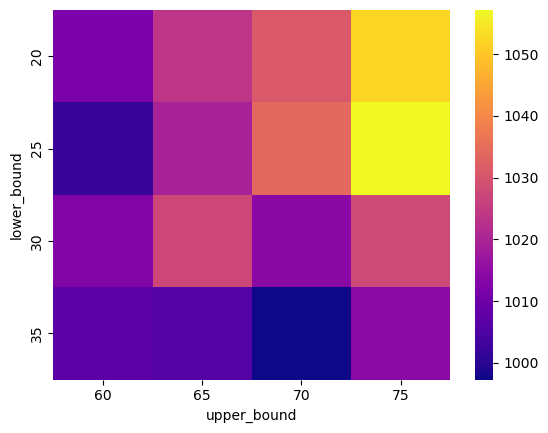

In [69]:
hm = heatmap.groupby(["lower_bound", "upper_bound"]).mean().unstack()
sns.heatmap(hm, cmap="plasma")

### Multi-Timeframe

In [89]:
class MultiRsi(Strategy):
    lower_bound = 30
    upper_bound = 70
    rsi_window = 14

    def init(self):
        self.daily_rsi = self.I(
            talib.STOCHRSI, self.data.Close, self.rsi_window
        )
        self.weekly_rsi = resample_apply(
            "W-FRI", talib.STOCHRSI, self.data.Close, self.rsi_window
        )

    def next(self):
        daily_upper_crossover = crossover(self.daily_rsi, self.upper_bound)
        daily_lower_crossover = crossover(self.lower_bound, self.daily_rsi)
        weekly_upper_crossover = self.weekly_rsi[-1] > self.upper_bound
        weekly_lower_crossover = self.lower_bound > self.weekly_rsi[-1]

        if daily_upper_crossover and weekly_upper_crossover:
            self.position.close()
        elif daily_lower_crossover and weekly_lower_crossover:
            self.buy()

In [90]:
bt = Backtest(strategy=MultiRsi, **BACKTEST_COMMON)
stats = bt.run()
bt.plot(**get_backtesting_plot_kwargs(stats))
stats

/opt/conda/envs/default/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/opt/conda/envs/default/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/opt/conda/envs/default/lib/python3.10/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/opt/conda/envs/default/lib/python3.10/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


Start                     2012-01-03 00:00:00
End                       2012-12-31 00:00:00
Duration                    363 days 00:00:00
Exposure Time [%]                        23.2
Equity Final [$]                    1043.2716
Equity Peak [$]                     1065.6316
Return [%]                            4.32716
Buy & Hold Return [%]                6.307389
Return (Ann.) [%]                    4.362522
Volatility (Ann.) [%]                5.807959
Sharpe Ratio                         0.751128
Sortino Ratio                        1.372163
Calmar Ratio                         1.540418
Max. Drawdown [%]                   -2.832038
Avg. Drawdown [%]                   -1.410753
Max. Drawdown Duration      146 days 00:00:00
Avg. Drawdown Duration       26 days 00:00:00
# Trades                                    2
Win Rate [%]                            100.0
Best Trade [%]                       5.250892
Worst Trade [%]                      1.447986
Avg. Trade [%]                    

In [91]:
stats["_trades"]

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,1,106,129,576.6009,584.95,8.3491,0.014480,2012-06-05,2012-07-09,34 days
1,1,216,249,665.0775,700.00,34.9225,0.052509,2012-11-12,2012-12-31,49 days
